# 🧠 Image Model — CT Scan Stroke Detection
### EfficientNetB0 with Transfer Learning
---

## Cell 1 — Install & Import Libraries

In [ ]:
# !pip install tensorflow opencv-python matplotlib seaborn scikit-learn

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import cv2
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_auc_score, roc_curve
)

print(f'TensorFlow : {tf.__version__}')
print(f'GPU        : {tf.config.list_physical_devices("GPU")}')
print('✅  All libraries loaded!')

TensorFlow : 2.20.0
GPU        : []
✅  All libraries loaded!


## Cell 2 — Configuration

In [ ]:
import os

# ── Paths ───────────────────────────────────────────────────────────
IMG_BASE  = r'D:\Greaduation Project\data\augmented'

TRAIN_DIR = f'{IMG_BASE}/Train'
VAL_DIR   = f'{IMG_BASE}/Validation'
TEST_DIR  = f'{IMG_BASE}/Test'

# ── Model settings ──────────────────────────────────────────────────
IMG_SIZE   = (224, 224)
BATCH_SIZE = 32
CLASSES    = ['Normal', 'Stroke']

os.makedirs('models',  exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# ── Count images ────────────────────────────────────────────────────
print('📊 Dataset Summary:')
print('-' * 40)

for split in ['Train', 'Validation', 'Test']:
    path = f'{IMG_BASE}/{split}'
    for cls in CLASSES:
        cls_path = f'{path}/{cls}'
        if os.path.exists(cls_path):
            n = len(os.listdir(cls_path))
            print(f'  {split:10} | {cls:7} | {n:5} images')

print('-' * 40)

📊 Dataset Summary:
----------------------------------------
  Train      | Normal  |  5129 images
  Train      | Stroke  | 16229 images
  Validation | Normal  |   167 images
  Validation | Stroke  |   415 images
  Test       | Normal  |    56 images
  Test       | Stroke  |   498 images
----------------------------------------


## Cell 3 — Visualize Sample CT Scans

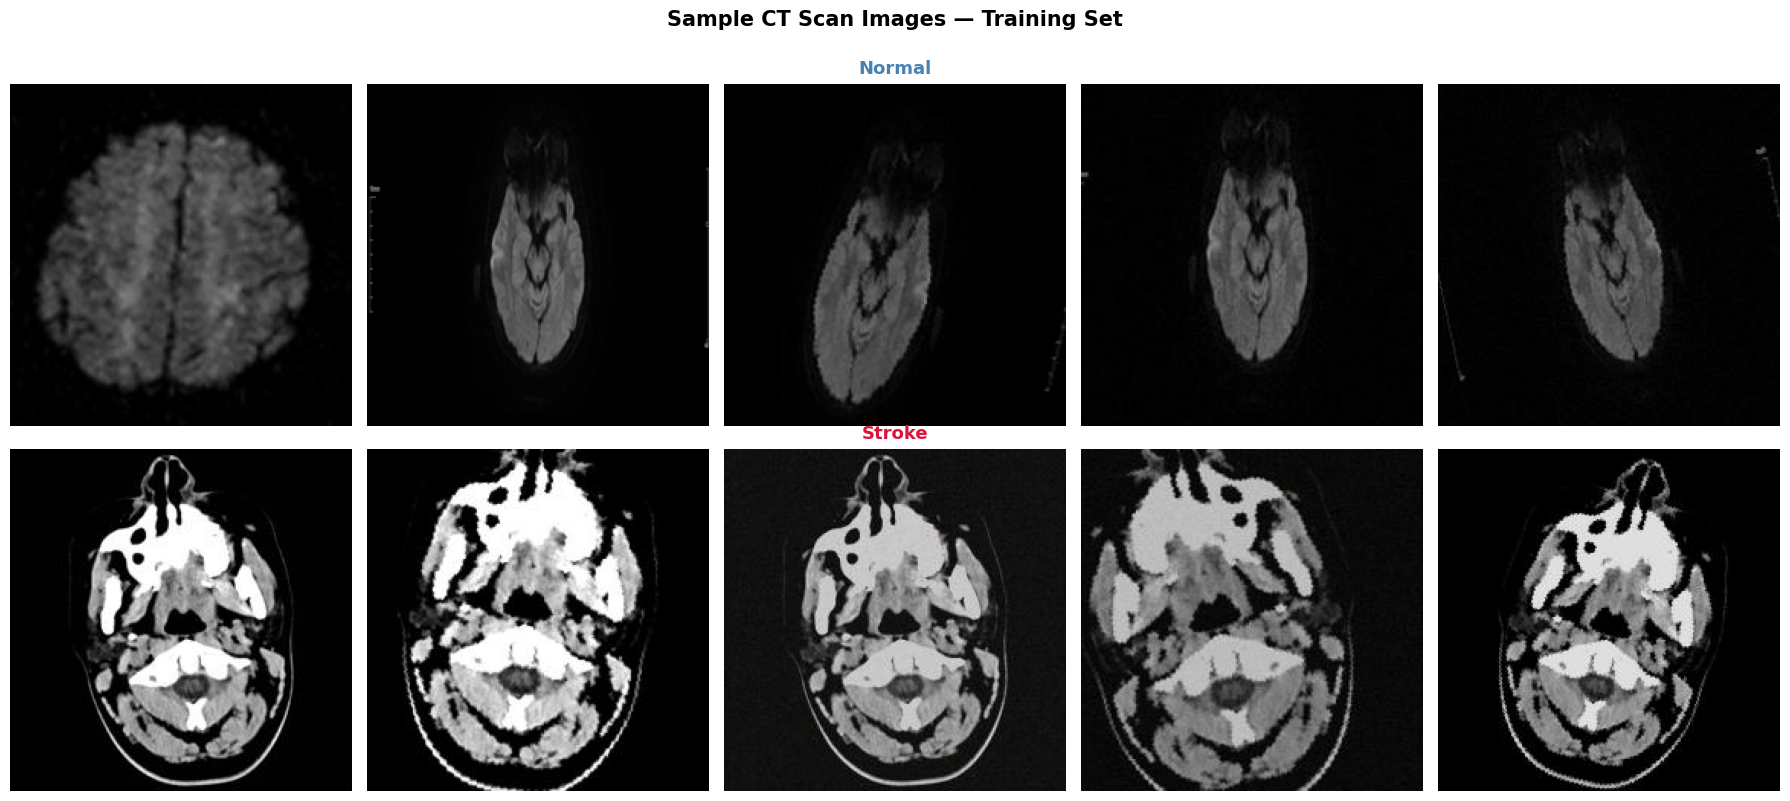

✅  Saved → outputs/ct_samples.png


In [ ]:
def load_samples(folder, n=5):
    files = [f for f in os.listdir(folder)
             if f.lower().endswith(('.jpg','.jpeg','.png'))]
    files = files[:n]
    imgs  = []
    for f in files:
        img = cv2.imread(os.path.join(folder, f))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, IMG_SIZE)
        imgs.append(img)
    return imgs

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
colors = {'Normal': 'steelblue', 'Stroke': 'crimson'}

for row, cls in enumerate(CLASSES):
    samples = load_samples(f'{TRAIN_DIR}/{cls}', n=5)
    for col, (ax, img) in enumerate(zip(axes[row], samples)):
        ax.imshow(img, cmap='gray' if img.mean() < 100 else None)
        ax.axis('off')
        if col == 2:
            ax.set_title(cls, fontsize=13, fontweight='bold',
                         color=colors[cls], pad=8)

plt.suptitle('Sample CT Scan Images — Training Set',
             fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('outputs/ct_samples.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅  Saved → outputs/ct_samples.png')

## Cell 4 — Data Generators

In [ ]:
# Train: بس rescale لأن الصور اتعملها augmentation بالفعل في الملف التاني
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='binary', seed=42
)
val_gen = val_datagen.flow_from_directory(
    VAL_DIR, target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE,
    batch_size=BATCH_SIZE, class_mode='binary', shuffle=False
)

print(f'Class mapping : {train_gen.class_indices}')
print(f'Train batches : {len(train_gen)}')
print(f'Val batches   : {len(val_gen)}')
print(f'Test batches  : {len(test_gen)}')
print('✅  Generators ready!')

Found 21358 images belonging to 2 classes.
Found 582 images belonging to 2 classes.
Found 554 images belonging to 2 classes.
Class mapping : {'Normal': 0, 'Stroke': 1}
Train batches : 668
Val batches   : 19
Test batches  : 18
✅  Generators ready!


## Cell 5 — Build EfficientNetB0 Model

In [ ]:
def build_model():
    # بنجيب EfficientNetB0 جاهز ومدرّب على ImageNet
    base = EfficientNetB0(
        include_top = False,
        weights     = 'imagenet',
        input_shape = (*IMG_SIZE, 3)
    )
    base.trainable = False   # Phase 1: الـ base مجمّد

    # بنضيف head جديد فوقيه
    inputs  = tf.keras.Input(shape=(*IMG_SIZE, 3))
    x       = base(inputs, training=False)
    x       = layers.GlobalAveragePooling2D()(x)
    x       = layers.BatchNormalization()(x)
    x       = layers.Dense(256, activation='relu')(x)
    x       = layers.Dropout(0.4)(x)
    x       = layers.Dense(128, activation='relu')(x)
    x       = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs, name='EfficientNetB0_StrokeCT')
    return model, base

image_model, base_model = build_model()

# Architecture summary
print(f'Total layers       : {len(image_model.layers)}')
print(f'Trainable params   : {image_model.count_params():,}')
image_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Total layers       : 9
Trainable params   : 4,415,652


Model: "EfficientNetB0_StrokeCT"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,415,652 (16.84 MB)

 Trainable params: 363,521 (1.39 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

## Cell 6 — Phase 1: Train Head Only (Base Frozen)

In [ ]:
image_model.compile(
    optimizer = optimizers.Adam(learning_rate=1e-3),
    loss      = 'binary_crossentropy',
    metrics   = [
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

callbacks_p1 = [
    EarlyStopping(monitor='val_auc', patience=5,
                  restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                      patience=3, verbose=1),
    ModelCheckpoint('models/image_model_phase1.keras',
                    monitor='val_auc', save_best_only=True,
                    mode='max', verbose=1)
]

print('Phase 1 — Training the head (base frozen)...')
history1 = image_model.fit(
    train_gen,
    epochs          = 20,
    validation_data = val_gen,
    callbacks       = callbacks_p1
)
print('\n✅  Phase 1 complete!')

Phase 1 — Training the head (base frozen)...


NameError: name 'callbacks_p1يي' is not defined

## Cell 7 — Phase 2: Fine-Tune Top Layers

In [ ]:
# بنفتح آخر 30 layer في الـ base عشان نـ fine-tune عليهم
base_model.trainable = True
FINE_TUNE_AT = len(base_model.layers) - 30

for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

trainable_count = sum(1 for l in image_model.layers if l.trainable)
print(f'Total base layers        : {len(base_model.layers)}')
print(f'Fine-tuning from layer   : {FINE_TUNE_AT}')
print(f'Total trainable layers   : {trainable_count}')

# بنـ compile بـ learning rate أصغر بكتير
image_model.compile(
    optimizer = optimizers.Adam(learning_rate=1e-4),
    loss      = 'binary_crossentropy',
    metrics   = [
        'accuracy',
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.Precision(name='precision')
    ]
)

callbacks_p2 = [
    EarlyStopping(monitor='val_auc', patience=7,
                  restore_best_weights=True, mode='max', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                      patience=3, verbose=1),
    ModelCheckpoint('models/image_model_best.keras',
                    monitor='val_auc', save_best_only=True,
                    mode='max', verbose=1)
]

print('\nPhase 2 — Fine-tuning top layers...')
history2 = image_model.fit(
    train_gen,
    epochs          = 30,
    validation_data = val_gen,
    callbacks       = callbacks_p2
)
print('\n✅  Phase 2 complete!')

## Cell 8 — Training Curves

In [ ]:
# دمج الـ history من الـ phase التاني
acc   = history1.history['accuracy']     + history2.history['accuracy']
val_a = history1.history['val_accuracy'] + history2.history['val_accuracy']
loss  = history1.history['loss']         + history2.history['loss']
val_l = history1.history['val_loss']     + history2.history['val_loss']
auc   = history1.history['auc']          + history2.history['auc']
val_u = history1.history['val_auc']      + history2.history['val_auc']

p1_end = len(history1.history['accuracy'])   # نقطة بداية الـ fine-tuning

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (train_vals, val_vals, title, color) in zip(axes, [
    (acc,  val_a, 'Accuracy',  'steelblue'),
    (loss, val_l, 'Loss',      'salmon'),
    (auc,  val_u, 'AUC-ROC',   'seagreen'),
]):
    ax.plot(train_vals, label=f'Train {title}', color=color,      lw=2)
    ax.plot(val_vals,   label=f'Val {title}',   color=color, lw=2, ls='--')
    ax.axvline(p1_end - 1, color='gray', ls=':', lw=1.5,
               label='Fine-tune start')
    ax.set_title(f'{title} — Training History', fontweight='bold')
    ax.set_xlabel('Epoch')
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.suptitle('EfficientNetB0 Training Curves (Phase 1 + Phase 2)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅  Saved → outputs/training_curves.png')

## Cell 9 — Evaluate on Test Set

In [ ]:
test_gen.reset()
y_prob = image_model.predict(test_gen, verbose=1).flatten()
y_true = test_gen.classes
y_pred = (y_prob >= 0.5).astype(int)

acc  = accuracy_score(y_true, y_pred)
auc  = roc_auc_score(y_true, y_prob)

print('=' * 55)
print('      IMAGE MODEL — TEST SET EVALUATION')
print('=' * 55)
print(f'  Accuracy  : {acc:.4f}')
print(f'  AUC-ROC   : {auc:.4f}')
print()
print(classification_report(y_true, y_pred,
                             target_names=['Normal', 'Stroke']))
print('=' * 55)

## Cell 10 — Confusion Matrix & ROC Curve

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal','Stroke'],
            yticklabels=['Normal','Stroke'],
            linewidths=0.5, linecolor='white',
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0].set_title('Confusion Matrix — Image Model',
                  fontweight='bold', fontsize=13)
axes[0].set_ylabel('Actual Label',    fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)
axes[1].plot(fpr, tpr, color='steelblue', lw=2.5,
             label=f'EfficientNetB0  (AUC = {auc_score:.3f})')
axes[1].fill_between(fpr, tpr, alpha=0.1, color='steelblue')
axes[1].plot([0,1],[0,1], '--', color='gray', lw=1.5, label='Random Classifier')
axes[1].set_title('ROC Curve — Image Model',
                  fontweight='bold', fontsize=13)
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate',  fontsize=11)
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/image_model_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅  Saved → outputs/image_model_evaluation.png')

## Cell 11 — Grad-CAM (إيه اللي المودل بيشوفه في الصورة)

In [ ]:
def get_gradcam_heatmap(model, img_array, last_conv_layer_name):
    """
    بيعمل heatmap يوضح الجزء من الصورة
    اللي المودل اعتمد عليه في قراره
    """
    grad_model = tf.keras.models.Model(
        inputs  = model.inputs,
        outputs = [model.get_layer(last_conv_layer_name).output,
                   model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads      = tape.gradient(loss, conv_outputs)
    pooled     = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_out   = conv_outputs[0]
    heatmap    = conv_out @ pooled[..., tf.newaxis]
    heatmap    = tf.squeeze(heatmap)
    heatmap    = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()


def overlay_gradcam(img_path, model, last_conv='top_conv'):
    # Load & preprocess
    img_orig  = cv2.imread(img_path)
    img_orig  = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img_orig  = cv2.resize(img_orig, IMG_SIZE)
    img_array = np.expand_dims(img_orig / 255.0, axis=0).astype(np.float32)

    # Predict
    score     = float(model.predict(img_array, verbose=0)[0][0])
    label     = 'Stroke' if score >= 0.5 else 'Normal'

    # Grad-CAM
    heatmap   = get_gradcam_heatmap(model, img_array, last_conv)
    heatmap   = cv2.resize(heatmap, IMG_SIZE)
    heatmap   = np.uint8(255 * heatmap)
    colormap  = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    colormap  = cv2.cvtColor(colormap, cv2.COLOR_BGR2RGB)
    overlay   = cv2.addWeighted(img_orig, 0.6, colormap, 0.4, 0)

    return img_orig, overlay, score, label


# ── Run on 6 test samples (3 Normal + 3 Stroke) ─────────────────────
fig, axes = plt.subplots(4, 6, figsize=(20, 14))
titles_row = ['Original', 'Grad-CAM']

col = 0
for cls in CLASSES:
    test_folder = f'{TEST_DIR}/{cls}'
    test_files  = [f'{test_folder}/{f}' for f in os.listdir(test_folder)
                   if f.lower().endswith(('.jpg','.png','.jpeg'))][:3]

    for f in test_files:
        orig, overlay, score, pred_label = overlay_gradcam(f, image_model)
        color = 'crimson' if pred_label == 'Stroke' else 'steelblue'

        axes[0, col].imshow(orig)
        axes[0, col].set_title(f'Original\n({cls})', fontsize=9)
        axes[0, col].axis('off')

        axes[1, col].imshow(overlay)
        axes[1, col].set_title(f'Grad-CAM\nPred: {pred_label} ({score:.2f})',
                               fontsize=9, color=color, fontweight='bold')
        axes[1, col].axis('off')
        col += 1

# Hide unused axes
for ax in axes[2:].flat:
    ax.axis('off')

plt.suptitle('Grad-CAM Visualization — What the Model Focuses On',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('outputs/gradcam_visualization.png', dpi=150, bbox_inches='tight')
plt.show()
print('✅  Saved → outputs/gradcam_visualization.png')

## Cell 12 — Save Model & Probabilities

In [ ]:
# Save the final model
image_model.save('models/image_model_final.keras')

# Save test probabilities (هيتستخدموا في الـ Fusion Model)
np.save('models/image_probs_test.npy',  y_prob)
np.save('models/image_labels_test.npy', y_true)

print('✅  Model saved!')
print('   → models/image_model_final.keras')
print('   → models/image_probs_test.npy')
print()
print('📊  Final Results Summary:')
print(f'   Accuracy : {accuracy_score(y_true, y_pred):.4f}')
print(f'   AUC-ROC  : {roc_auc_score(y_true, y_prob):.4f}')